In [1]:
# importacao das bibliotecas utilizadas
import numpy as np
import cv2
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importacao das imagens
foto1a = plt.imread('imgs/foto1A.jpg')
foto1b = plt.imread('imgs/foto1B.jpg')
foto2a = plt.imread('imgs/foto3A.jpg')
foto2b = plt.imread('imgs/foto3B.jpg')

In [3]:
# funcoes extras
def plot_images(img1, img2):
    f = plt.figure(figsize=(15,8))
    
    f.add_subplot(1,2,1)
    plt.imshow(img1,'gray')
    
    f.add_subplot(1,2,2)
    plt.imshow(img2,'gray')
    
    plt.show()

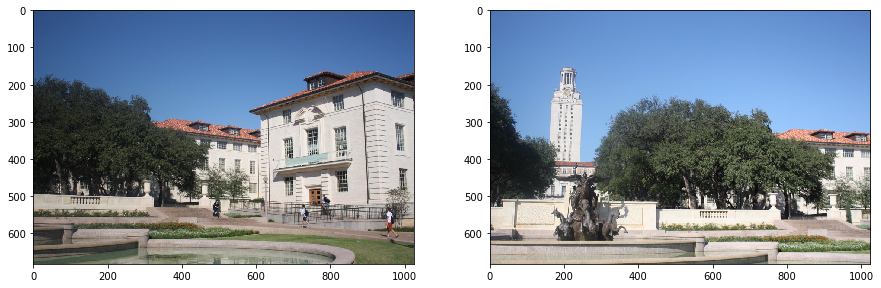

In [4]:
plot_images(foto1a, foto1b)

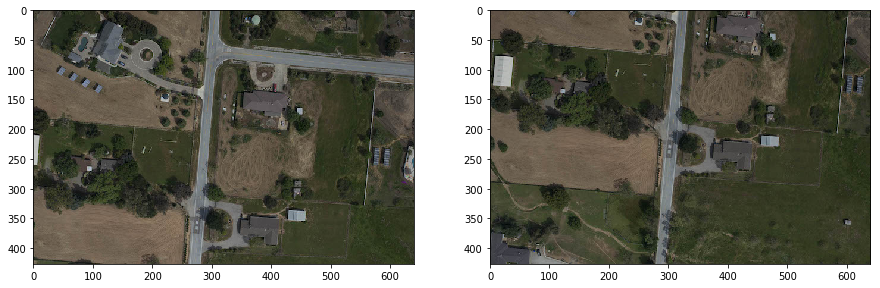

In [5]:
plot_images(foto2a, foto2b)

### (1)

In [6]:
foto1a_g = cv2.cvtColor(foto1a, cv2.COLOR_BGR2GRAY)
foto1b_g = cv2.cvtColor(foto1b, cv2.COLOR_BGR2GRAY)
foto2a_g = cv2.cvtColor(foto2a, cv2.COLOR_BGR2GRAY)
foto2b_g = cv2.cvtColor(foto2b, cv2.COLOR_BGR2GRAY)

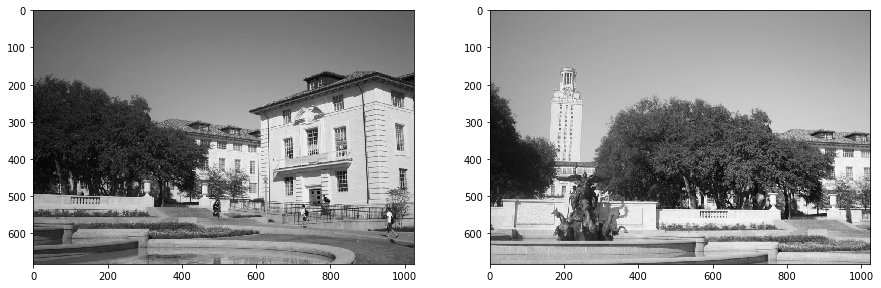

In [7]:
plot_images(foto1a_g,foto1b_g)

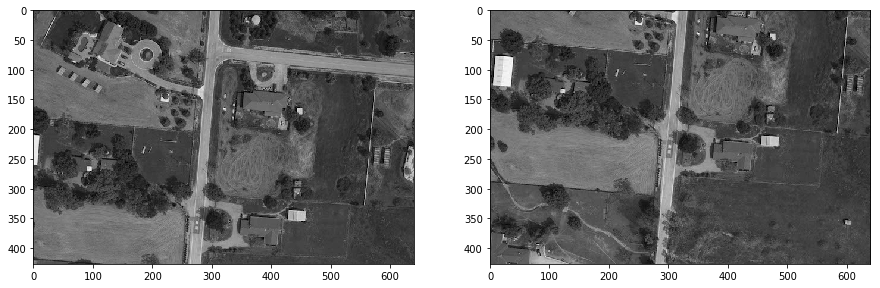

In [8]:
plot_images(foto2a_g,foto2b_g)

### (2)

In [9]:
sift = cv2.xfeatures2d.SIFT_create()
surf = cv2.xfeatures2d.SURF_create()
star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
orb = cv2.ORB_create()

In [10]:
# SIFT
sift_kp_foto1a_g, sift_f_foto1a_g = sift.detectAndCompute(foto1a_g,None)
sift_kp_foto1b_g, sift_f_foto1b_g = sift.detectAndCompute(foto1b_g,None)
sift_kp_foto2a_g, sift_f_foto2a_g = sift.detectAndCompute(foto2a_g,None)
sift_kp_foto2b_g, sift_f_foto2b_g = sift.detectAndCompute(foto2b_g,None)

In [11]:
sift_kp_foto1a_g = np.float32([kp.pt for kp in sift_kp_foto1a_g])
sift_kp_foto1b_g = np.float32([kp.pt for kp in sift_kp_foto1b_g])
sift_kp_foto2a_g = np.float32([kp.pt for kp in sift_kp_foto2a_g])
sift_kp_foto2b_g = np.float32([kp.pt for kp in sift_kp_foto2b_g])

In [12]:
# SURF
surf_kp_foto1a_g, surf_f_foto1a_g = surf.detectAndCompute(foto1a_g,None)
surf_kp_foto1b_g, surf_f_foto1b_g = surf.detectAndCompute(foto1b_g,None)
surf_kp_foto2a_g, surf_f_foto2a_g = surf.detectAndCompute(foto2a_g,None)
surf_kp_foto2b_g, surf_f_foto2b_g = surf.detectAndCompute(foto2b_g,None)

In [13]:
surf_kp_foto1a_g = np.float32([kp.pt for kp in surf_kp_foto1a_g])
surf_kp_foto1b_g = np.float32([kp.pt for kp in surf_kp_foto1b_g])
surf_kp_foto2a_g = np.float32([kp.pt for kp in surf_kp_foto2a_g])
surf_kp_foto2b_g = np.float32([kp.pt for kp in surf_kp_foto2b_g])

In [14]:
# BRIEF
kp_foto1a_g = star.detect(foto1a_g,None)
kp_foto1b_g = star.detect(foto1b_g,None)
kp_foto2a_g = star.detect(foto2a_g,None)
kp_foto2b_g = star.detect(foto2b_g,None)

In [15]:
brief_kp_foto1a_g, brief_f_foto1a_g = brief.compute(foto1a_g,kp_foto1a_g)
brief_kp_foto1b_g, brief_f_foto1b_g = brief.compute(foto1b_g,kp_foto1b_g)
brief_kp_foto2a_g, brief_f_foto2a_g = brief.compute(foto2a_g,kp_foto2a_g)
brief_kp_foto2b_g, brief_f_foto2b_g = brief.compute(foto2b_g,kp_foto2b_g)

In [16]:
brief_kp_foto1a_g = np.float32([kp.pt for kp in brief_kp_foto1a_g])
brief_kp_foto1b_g = np.float32([kp.pt for kp in brief_kp_foto1b_g])
brief_kp_foto2a_g = np.float32([kp.pt for kp in brief_kp_foto2a_g])
brief_kp_foto2b_g = np.float32([kp.pt for kp in brief_kp_foto2b_g])

In [17]:
# ORB
kp_foto1a_g = orb.detect(foto1a_g,None)
kp_foto1b_g = orb.detect(foto1b_g,None)
kp_foto2a_g = orb.detect(foto2a_g,None)
kp_foto2b_g = orb.detect(foto2b_g,None)

In [18]:
orb_kp_foto1a_g, orb_f_foto1a_g = orb.compute(foto1a_g, kp_foto1a_g)
orb_kp_foto1b_g, orb_f_foto1b_g = orb.compute(foto1b_g, kp_foto1b_g)
orb_kp_foto2a_g, orb_f_foto2a_g = orb.compute(foto2a_g, kp_foto2a_g)
orb_kp_foto2b_g, orb_f_foto2b_g = orb.compute(foto2b_g, kp_foto2b_g)

In [19]:
orb_kp_foto1a_g = np.float32([kp.pt for kp in orb_kp_foto1a_g])
orb_kp_foto1b_g = np.float32([kp.pt for kp in orb_kp_foto1b_g])
orb_kp_foto2a_g = np.float32([kp.pt for kp in orb_kp_foto2a_g])
orb_kp_foto2b_g = np.float32([kp.pt for kp in orb_kp_foto2b_g])

### (3)

In [20]:
matcher = cv2.DescriptorMatcher_create("BruteForce")

In [21]:
sift_rawMatches_foto1 = matcher.knnMatch(sift_f_foto1a_g, sift_f_foto1b_g, 2)
surf_rawMatches_foto1 = matcher.knnMatch(surf_f_foto1a_g, surf_f_foto1b_g, 2)
brief_rawMatches_foto1 = matcher.knnMatch(brief_f_foto1a_g, brief_f_foto1b_g, 2)
orb_rawMatches_foto1 = matcher.knnMatch(orb_f_foto1a_g, orb_f_foto1b_g, 2)

sift_rawMatches_foto2 = matcher.knnMatch(sift_f_foto2a_g, sift_f_foto2b_g, 2)
surf_rawMatches_foto2 = matcher.knnMatch(surf_f_foto2a_g, surf_f_foto2b_g, 2)
brief_rawMatches_foto2 = matcher.knnMatch(brief_f_foto2a_g, brief_f_foto2b_g, 2)
orb_rawMatches_foto2 = matcher.knnMatch(orb_f_foto2a_g, orb_f_foto2b_g, 2)

### (4)

In [22]:
def best_matches(match, ratio = 0.8):
    matches = []
    for m in match:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    
    return matches

In [23]:
match_sift_foto1 = best_matches(sift_rawMatches_foto1)
match_surf_foto1 = best_matches(surf_rawMatches_foto1)
match_brief_foto1 = best_matches(brief_rawMatches_foto1)
match_orb_foto1 = best_matches(orb_rawMatches_foto1)

match_sift_foto2 = best_matches(sift_rawMatches_foto2)
match_surf_foto2 = best_matches(surf_rawMatches_foto2)
match_brief_foto2 = best_matches(brief_rawMatches_foto2)
match_orb_foto2 = best_matches(orb_rawMatches_foto2)

### (5)

In [24]:
def calculate_homography(matches, kpsA, kpsB, thr = 4.0):
    if len(matches) > 4:
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])
        
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, thr)
        
        return (H, status)
    return None

In [25]:
sift_h_foto1 = calculate_homography(match_sift_foto1, sift_kp_foto1a_g, sift_kp_foto1b_g)
surf_h_foto1 = calculate_homography(match_surf_foto1, surf_kp_foto1a_g, surf_kp_foto1b_g)
brief_h_foto1 = calculate_homography(match_brief_foto1, brief_kp_foto1a_g, brief_kp_foto1b_g)
orb_h_foto1 = calculate_homography(match_orb_foto1, orb_kp_foto1a_g, orb_kp_foto1b_g)

sift_h_foto2 = calculate_homography(match_sift_foto2, sift_kp_foto2a_g, sift_kp_foto2b_g)
surf_h_foto2 = calculate_homography(match_surf_foto2, surf_kp_foto2a_g, surf_kp_foto2b_g)
brief_h_foto2 = calculate_homography(match_brief_foto2, brief_kp_foto2a_g, brief_kp_foto2b_g)
orb_h_foto2 = calculate_homography(match_orb_foto2, orb_kp_foto2a_g, orb_kp_foto2b_g)

### (6)

In [26]:
sift_persp_foto1 = cv2.warpPerspective(foto1a_g, sift_h_foto1[0], (foto1a_g.shape[1] + foto1b_g.shape[1], foto1a_g.shape[0]))
surf_persp_foto1 = cv2.warpPerspective(foto1a_g, surf_h_foto1[0], (foto1a_g.shape[1] + foto1b_g.shape[1], foto1a_g.shape[0]))
brief_persp_foto1 = cv2.warpPerspective(foto1a_g, brief_h_foto1[0], (foto1a_g.shape[1] + foto1b_g.shape[1], foto1a_g.shape[0]))
orb_persp_foto1 = cv2.warpPerspective(foto1a_g, orb_h_foto1[0], (foto1a_g.shape[1] + foto1b_g.shape[1], foto1a_g.shape[0]))

sift_persp_foto2 = cv2.warpPerspective(foto2a_g, sift_h_foto2[0], (foto2a_g.shape[1] + foto2b_g.shape[1], foto2a_g.shape[0]))
surf_persp_foto2 = cv2.warpPerspective(foto2a_g, surf_h_foto2[0], (foto2a_g.shape[1] + foto2b_g.shape[1], foto2a_g.shape[0]))
brief_persp_foto2 = cv2.warpPerspective(foto2a_g, brief_h_foto2[0], (foto2a_g.shape[1] + foto2b_g.shape[1], foto2a_g.shape[0]))
orb_persp_foto2 = cv2.warpPerspective(foto2a_g, orb_h_foto2[0], (foto2a_g.shape[1] + foto2b_g.shape[1], foto2a_g.shape[0]))

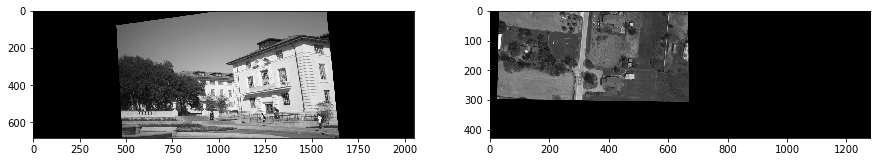

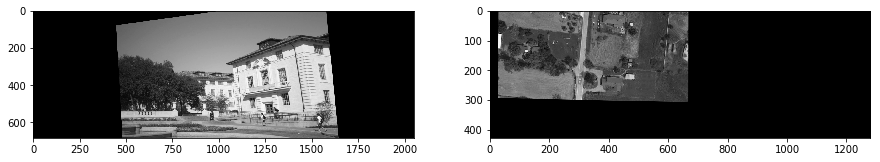

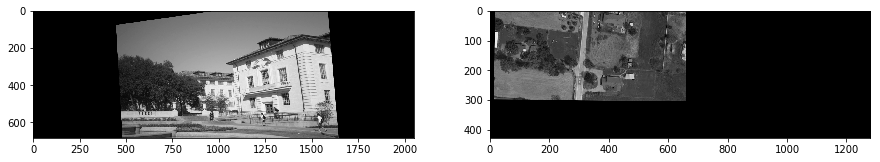

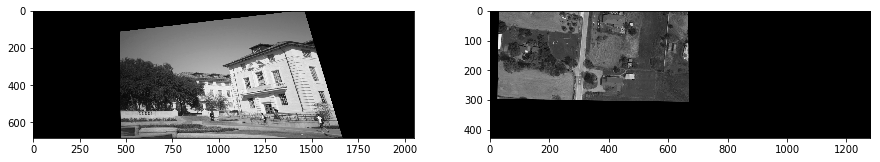

In [27]:
plot_images(sift_persp_foto1, sift_persp_foto2)
plot_images(surf_persp_foto1, surf_persp_foto2)
plot_images(brief_persp_foto1, brief_persp_foto2)
plot_images(orb_persp_foto1, orb_persp_foto2)

In [35]:
plt.imsave('resultados/sift_persp_inter_foto1.jpeg', sift_persp_foto1, cmap='gray')
plt.imsave('resultados/surf_persp_inter_foto1.jpeg', surf_persp_foto1, cmap='gray')
plt.imsave('resultados/brief_persp_inter_foto1.jpeg', brief_persp_foto1, cmap='gray')
plt.imsave('resultados/orb_persp_inter_foto1.jpeg', orb_persp_foto1, cmap='gray')

plt.imsave('resultados/sift_persp_inter_foto2.jpeg', sift_persp_foto2, cmap='gray')
plt.imsave('resultados/surf_persp_inter_foto2.jpeg', surf_persp_foto2, cmap='gray')
plt.imsave('resultados/brief_persp_inter_foto2.jpeg', brief_persp_foto2, cmap='gray')
plt.imsave('resultados/orb_persp_inter_foto2.jpeg', orb_persp_foto2, cmap='gray')

### (7)

In [28]:
sift_persp_foto1[0:foto1b_g.shape[0], 0:foto1b_g.shape[1]] = foto1b_g
surf_persp_foto1[0:foto1b_g.shape[0], 0:foto1b_g.shape[1]] = foto1b_g
brief_persp_foto1[0:foto1b_g.shape[0], 0:foto1b_g.shape[1]] = foto1b_g
orb_persp_foto1[0:foto1b_g.shape[0], 0:foto1b_g.shape[1]] = foto1b_g

sift_persp_foto2[0:foto2b_g.shape[0], 0:foto2b_g.shape[1]] = foto2b_g
surf_persp_foto2[0:foto2b_g.shape[0], 0:foto2b_g.shape[1]] = foto2b_g
brief_persp_foto2[0:foto2b_g.shape[0], 0:foto2b_g.shape[1]] = foto2b_g
orb_persp_foto2[0:foto2b_g.shape[0], 0:foto2b_g.shape[1]] = foto2b_g

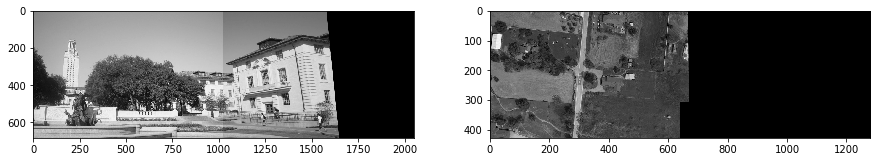

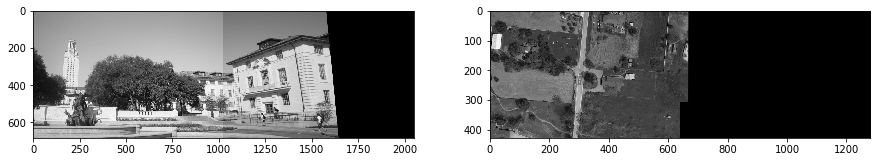

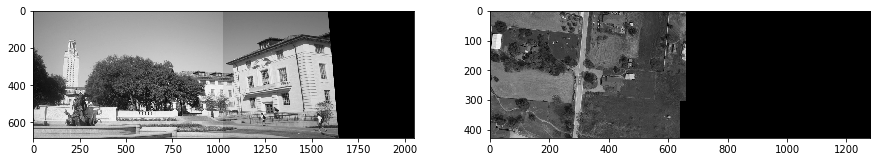

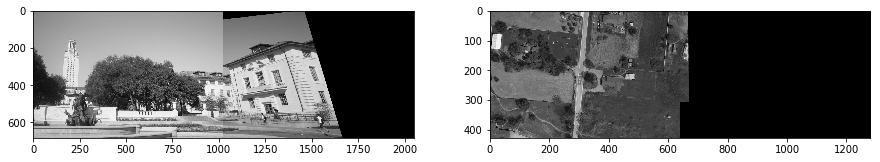

In [29]:
plot_images(sift_persp_foto1, sift_persp_foto2)
plot_images(surf_persp_foto1, surf_persp_foto2)
plot_images(brief_persp_foto1, brief_persp_foto2)
plot_images(orb_persp_foto1, orb_persp_foto2)

In [36]:
plt.imsave('resultados/sift_persp_foto1.jpeg', sift_persp_foto1, cmap='gray')
plt.imsave('resultados/surf_persp_foto1.jpeg', surf_persp_foto1, cmap='gray')
plt.imsave('resultados/brief_persp_foto1.jpeg', brief_persp_foto1, cmap='gray')
plt.imsave('resultados/orb_persp_foto1.jpeg', orb_persp_foto1, cmap='gray')

plt.imsave('resultados/sift_persp_foto2.jpeg', sift_persp_foto2, cmap='gray')
plt.imsave('resultados/surf_persp_foto2.jpeg', surf_persp_foto2, cmap='gray')
plt.imsave('resultados/brief_persp_foto2.jpeg', brief_persp_foto2, cmap='gray')
plt.imsave('resultados/orb_persp_foto2.jpeg', orb_persp_foto2, cmap='gray')

### (8)

In [30]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    for ((trainIdx, queryIdx), s) in zip(matches, status):
        if s == 1:
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
            
    return vis

In [31]:
sift_vis_foto1 = drawMatches(foto1a, foto1b, sift_kp_foto1a_g, sift_kp_foto1b_g, match_sift_foto1, sift_h_foto1[1])
surf_vis_foto1 = drawMatches(foto1a, foto1b, surf_kp_foto1a_g, surf_kp_foto1b_g, match_surf_foto1, surf_h_foto1[1])
brief_vis_foto1 = drawMatches(foto1a, foto1b, brief_kp_foto1a_g, brief_kp_foto1b_g, match_brief_foto1, brief_h_foto1[1])
orb_vis_foto1 = drawMatches(foto1a, foto1b, orb_kp_foto1a_g, orb_kp_foto1b_g, match_orb_foto1, orb_h_foto1[1])

sift_vis_foto2 = drawMatches(foto2a, foto2b, sift_kp_foto2a_g, sift_kp_foto2b_g, match_sift_foto2, sift_h_foto2[1])
surf_vis_foto2 = drawMatches(foto2a, foto2b, surf_kp_foto2a_g, surf_kp_foto2b_g, match_surf_foto2, surf_h_foto2[1])
brief_vis_foto2 = drawMatches(foto2a, foto2b, brief_kp_foto2a_g, brief_kp_foto2b_g, match_brief_foto2, brief_h_foto2[1])
orb_vis_foto2 = drawMatches(foto2a, foto2b, orb_kp_foto2a_g, orb_kp_foto2b_g, match_orb_foto2, orb_h_foto2[1])

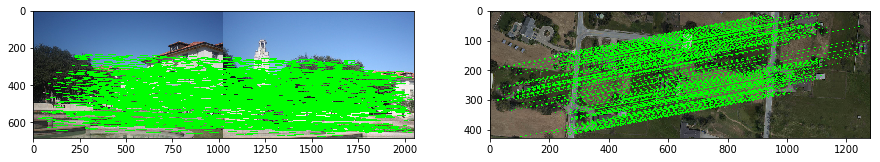

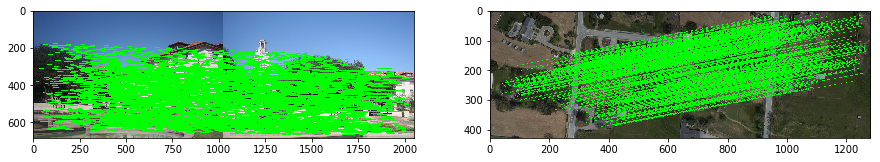

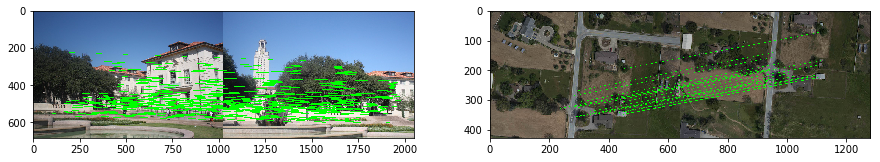

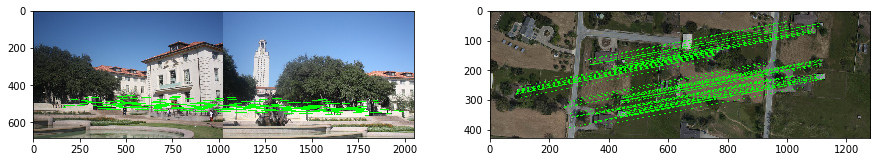

In [32]:
plot_images(sift_vis_foto1, sift_vis_foto2)
plot_images(surf_vis_foto1, surf_vis_foto2)
plot_images(brief_vis_foto1, brief_vis_foto2)
plot_images(orb_vis_foto1, orb_vis_foto2)

In [37]:
plt.imsave('resultados/sift_vis_foto1.jpeg', sift_vis_foto1)
plt.imsave('resultados/surf_vis_foto1.jpeg', surf_vis_foto1)
plt.imsave('resultados/brief_vis_foto1.jpeg', brief_vis_foto1)
plt.imsave('resultados/orb_vis_foto1.jpeg', orb_vis_foto1)

plt.imsave('resultados/sift_vis_foto2.jpeg', sift_vis_foto2)
plt.imsave('resultados/surf_vis_foto2.jpeg', surf_vis_foto2)
plt.imsave('resultados/brief_vis_foto2.jpeg', brief_vis_foto2)
plt.imsave('resultados/orb_vis_foto2.jpeg', orb_vis_foto2)